In [1]:
from metrics import (
    SquaredError, 
    
    FunctionClassError, 
    FCErrorQuadrants,
    FCErrorOrthogonal,
    FCErrorSeenPoints,
)
from metrics.utils import post_process, average_evals
from function_classes.wrappers import (
    ScaledXRegression,
    ScaledYRegression,
    NoisyXRegression,
    NoisyYRegression,
)

from models.linear import LeastSquaresModel, LassoModel
from models.zero_model import ZeroModel

from models.transformer import GPT2, Llama

from function_classes.linear import LinearRegression, SparseLinearRegression

import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
import torch

/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
#loading models:
def load_model(filename, model):
    content = torch.load(filename)
    model.load_state_dict(content["model_state_dict"])
    return model

#Model=load_model("stored_models/gpt2/checkpoint_495000", GPT2(x_dim=10, n_positions=101,  n_embd=256, n_layer=12, n_head=8))

In [3]:
B_SIZE, SEQ_LEN, X_DIM, Y_DIM = 128, 41, 20, 1
X_SHAPE = torch.Size([B_SIZE, SEQ_LEN, X_DIM])
Y_SHAPE = torch.Size([B_SIZE, SEQ_LEN, Y_DIM])

MODELS = [LassoModel(alpha=0.01, x_dim=X_DIM), LassoModel(alpha=0.02, x_dim=X_DIM), LassoModel(alpha=0.04, x_dim=X_DIM), LassoModel(alpha=0.08, x_dim=X_DIM)]

SCALES: list[float] = [0.125, 0.25, 0.5, 2., 4., 8.]
NOISE_LEVELS: list[float] = [0.0625, 0.125, 0.25, 0.5, 1.]

METRIC = SquaredError()

In [4]:
x_dist = MultivariateNormal(torch.zeros(X_SHAPE), torch.eye(X_DIM)) #batch size, sequence_length, x_dim

base_fc = SparseLinearRegression(3, x_dist, y_dim=Y_DIM)

bench = FunctionClassError(METRIC, function_class=base_fc)

In [17]:
def plot_comparison_2_models(MODELS=None, names=None,errs=None, post_processed_errs=None, post_processed_diff=None, title=None, confidence_level=[0.95, 0.99]): 
    #compares the two first models in values or errs
    #if diff or errs is included the difference in their losses is also plotted
    if post_processed_errs ==None and errs==None:
        print("Needs either post_processed_errs or errs to not be None")
        return 
    if names==None and MODELS ==None:
        print("Plotting function needs either names or the models themselves")
        return 
    if names==None:
        names=[model.name for model in MODELS]

    if post_processed_errs==None:
        post_processed_errs=post_process(errs, confidence_level=confidence_level)

    if post_processed_diff==None and errs!=None:
        post_processed_diff=post_process((errs[0]-errs[1]).unsqueeze(0), confidence_level=confidence_level)[0]
    if post_processed_diff==None:
        fig, axs =plt.subplots(1,2, figsize=(12, 12))
    else:
        fig, axs =plt.subplots(2,len(confidence_level), figsize=(12, 12))
        axs[1, 0].set_title(f"Loss of GPT2 minus loss of Llama, confidence 0.99") 
        axs[1, 1].set_title(f'Loss of GPT2 minus loss of Llama, confidence 0.95')
    axs[0, 0].set_title('Pure loss, confidence 0.99')
    axs[0, 1].set_title('Pure loss, confidence 0.95')
    xs=range(len(post_processed_diff["accuracy"][:, 0]))
    for name, results in zip(names, post_processed_errs):
        for i, level in enumerate(confidence_level):
            axs[0, i].plot(results["accuracy"][:, 0], label=name)
            axs[0, i].fill_between(xs, results[f"confidence_{level}_lower"][:, 0], results[f"confidence_{level}_upper"][:, 0], alpha=0.5)
            
    if post_processed_diff!=None:
        for i, level in enumerate(confidence_level):
            axs[1, 0].plot(post_processed_diff["accuracy"][:, 0])
            axs[1, 0].fill_between(xs, post_processed_diff[f"confidence_{level}_lower"][:, 0], post_processed_diff[f"confidence_{level}_upper"][:, 0], alpha=10.2-level*10)
            axs[1, 0].axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
       
    if title!=None:
        fig.suptitle(title)
    plt.show()


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


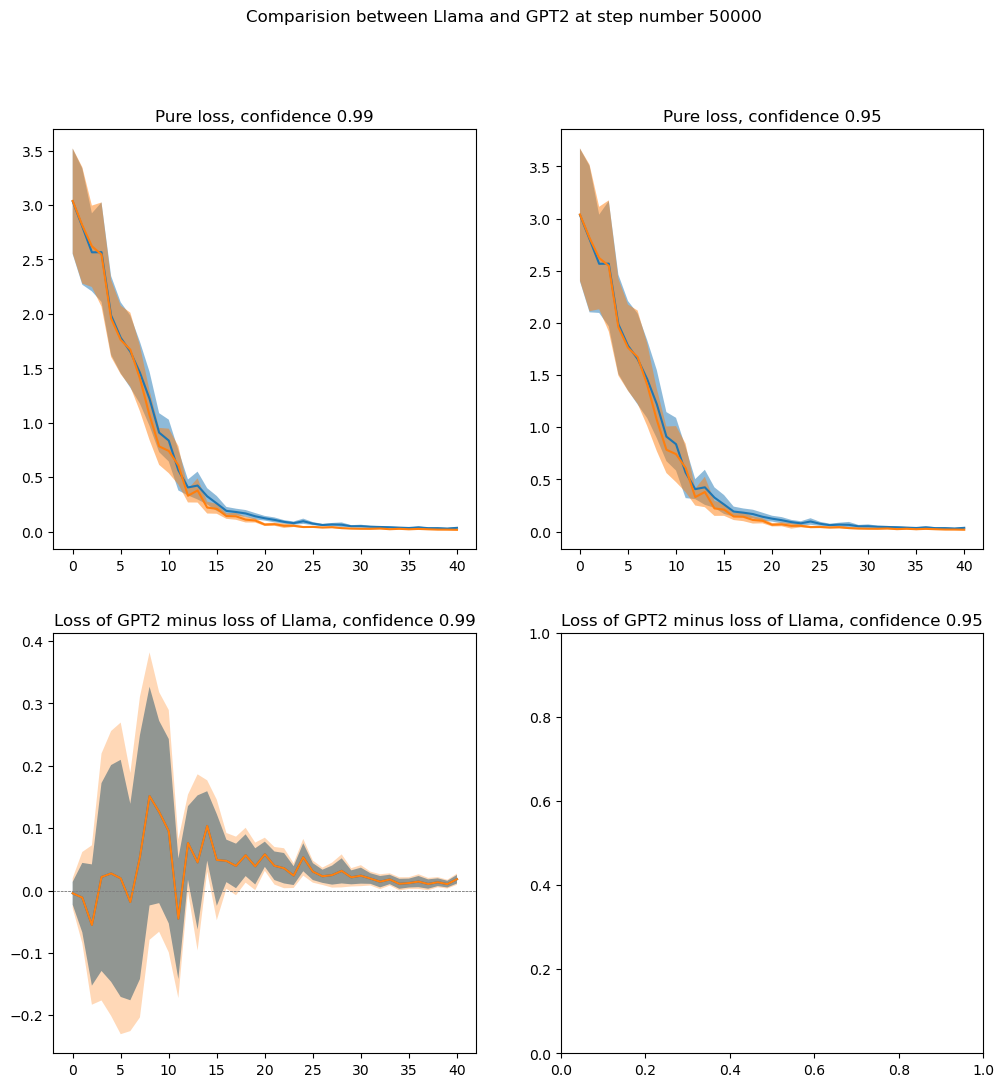

KeyboardInterrupt: 

In [18]:
for size in [50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000]:
    MODELS=[]

    Model1=load_model("stored_models/Sparse_linear/gpt2/checkpoint_"+str(size)+ " (3)", GPT2(x_dim=20, n_positions=101,  n_embd=256, n_layer=12, n_head=8))
    Model2=load_model("stored_models/Sparse_linear/Llama/checkpoint_"+str(size)+" (2)", Llama(x_dim=20, n_positions=101,  n_embd=256, n_layer=12, n_head=8))
    MODELS=[Model1.cuda(), Model2.cuda()]
    Model1=None
    Model2=None
    errs = average_evals(MODELS, bench, 2, 2)#bench.evaluate(MODELS, num_batches=64, perfect_model=LeastSquaresModel(x_dim=X_DIM))
    plot_comparison_2_models(MODELS, ["GPT2", "Llama"], errs, title=f"Comparision between Llama and GPT2 at step number {size}")

In [ ]:
errs = bench.evaluate(MODELS, num_batches=4)
values = list(post_process(errs))

dict_keys(['accuracy', 'std', 'std_mean', 'max', 'min', 'confidence_0.01_upper', 'confidence_0.01_lower', 'confidence_0.05_upper', 'confidence_0.05_lower', 'quantile_0.05', 'quantile_0.25', 'quantile_0.5', 'quantile_0.75', 'quantile_0.95'])
dict_keys(['accuracy', 'std', 'std_mean', 'max', 'min', 'confidence_0.01_upper', 'confidence_0.01_lower', 'confidence_0.05_upper', 'confidence_0.05_lower', 'quantile_0.05', 'quantile_0.25', 'quantile_0.5', 'quantile_0.75', 'quantile_0.95'])


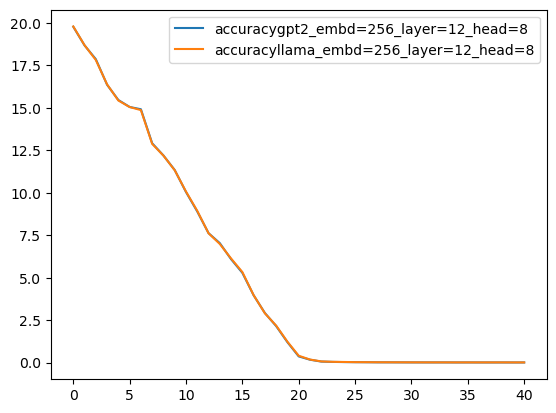

In [ ]:
for model, results in zip(MODELS, values):
    print(results.keys())
    plt.plot("accuracy", data=results, label="accuracy"+model.name)
plt.legend()
plt.show()

In [ ]:
scaled_x_fcs = [
    ScaledXRegression(scale, base_fc)
    for scale in SCALES
]
scaled_in_benches = [FunctionClassError(METRIC, function_class=fc) for fc in scaled_x_fcs]

scaled_y_fcs = [
    ScaledYRegression(scale, base_fc)
    for scale in SCALES
]
scaled_out_benches = [FunctionClassError(METRIC, function_class=fc) for fc in scaled_y_fcs]

noisy_x_fcs = [
    NoisyXRegression(
        MultivariateNormal(
            torch.zeros(X_SHAPE), 
            noise_level * torch.eye(X_DIM)
        ),
        base_fc 
    )
    for noise_level in NOISE_LEVELS
]
noise_in_benches = [FunctionClassError(METRIC, function_class=fc) for fc in noisy_x_fcs]

noisy_y_fcs = [
    NoisyYRegression(
        MultivariateNormal(
            torch.zeros(Y_SHAPE), 
            noise_level * torch.eye(Y_DIM)
        ),
        base_fc 
    )
    for noise_level in NOISE_LEVELS
]
noise_out_benches = [FunctionClassError(METRIC, function_class=fc) for fc in noisy_y_fcs]

In [ ]:
for b in scaled_in_benches:
    errs = b.evaluate(MODELS, num_batches=4)
    values = list(post_process(errs))
    for model, results in zip(MODELS, values):
        plt.title(f"Errors for X scaled by {b.fn_cls._scale}")  # pyright: ignore[reportAttributeAccessIssue]
        plt.plot("accuracy", data=results, label="accuracy")
        plt.plot("confidence_0.01_upper", data=results)
        plt.plot("confidence_0.01_lower", data=results)
        plt.legend()
        plt.show()
        break

AttributeError: 'FunctionClassError' object has no attribute 'fn_cls'

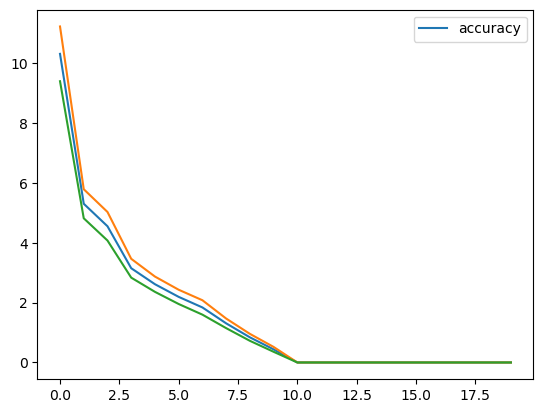

In [ ]:
bench = FCErrorQuadrants(METRIC, base_fc)
errs = bench.evaluate(MODELS, num_batches=4)
values = list(post_process(errs))
for model, results in zip(MODELS, values):
    plt.plot("accuracy", data=results, label="accuracy")
    plt.plot("confidence_0.01_upper", data=results)
    plt.plot("confidence_0.01_lower", data=results)
    plt.legend()
    plt.show()
    break


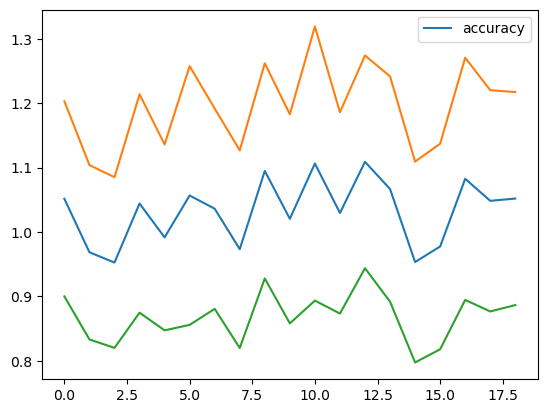

In [ ]:
bench = FCErrorOrthogonal(METRIC, base_fc)
errs = bench.evaluate(MODELS, num_batches=4)
values = list(post_process(errs))
for model, results in zip(MODELS, values):
    plt.plot("accuracy", data=results, label="accuracy")
    plt.plot("confidence_0.01_upper", data=results)
    plt.plot("confidence_0.01_lower", data=results)
    plt.legend()
    plt.show()
    break

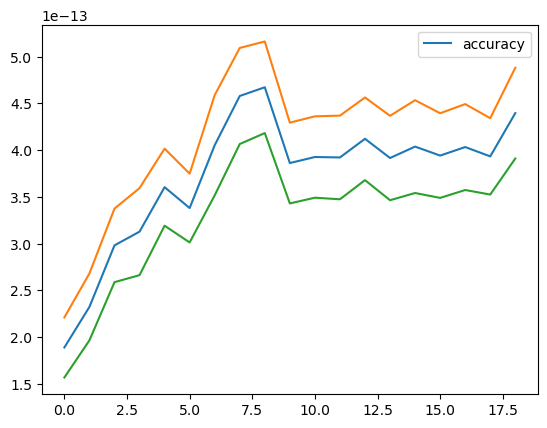

In [ ]:
bench = FCErrorSeenPoints(METRIC, base_fc)
errs = bench.evaluate(MODELS, num_batches=4)
values = list(post_process(errs))
for model, results in zip(MODELS, values):
    plt.plot("accuracy", data=results, label="accuracy")
    plt.plot("confidence_0.01_upper", data=results)
    plt.plot("confidence_0.01_lower", data=results)
    plt.legend()
    plt.show()
    break